In [1]:
!cd /home/ir739wb/ilyarekun/bc_project/federated-learning/fed-avg-code



In [2]:
import os
import flwr as fl
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
import numpy as np
import kagglehub
import shutil
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from flwr.common import parameters_to_ndarrays

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda:0


In [3]:
class BrainCNN(nn.Module):
    def __init__(self):
        super(BrainCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.45),
            nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.45),
            nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.45),
            nn.Conv2d(128, 256, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.45),
            nn.Conv2d(256, 256, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.4),
            nn.Conv2d(256, 512, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.4)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 3 * 3, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(512, 4),
        )
        
    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc_layers(out)
        return out

In [4]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [5]:
def data_preprocessing_tumor_stratified(num_clients=4):
    dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
    train_path = os.path.join(dataset_path, "Training")
    test_path = os.path.join(dataset_path, "Testing")
    general_dataset_path = os.path.join(dataset_path, "General_Dataset")
    os.makedirs(general_dataset_path, exist_ok=True)
    
    for source_path in [train_path, test_path]:
        for class_name in os.listdir(source_path):
            class_path = os.path.join(source_path, class_name)
            general_class_path = os.path.join(general_dataset_path, class_name)
            os.makedirs(general_class_path, exist_ok=True)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                shutil.move(img_path, os.path.join(general_class_path, img_name))
    
    transform = transforms.Compose([
        transforms.CenterCrop((400, 400)),
        transforms.Resize((200, 200)),
        transforms.ToTensor(),
    ])
    
    general_dataset = ImageFolder(root=general_dataset_path, transform=transform)
    targets = general_dataset.targets
    classes = list(set(targets))
    
    train_indices = []
    val_indices = []
    test_indices = []
    train_ratio = 0.7
    val_ratio = 0.2
    test_ratio = 0.1
    
    for class_label in classes:
        class_indices = [i for i, target in enumerate(targets) if target == class_label]
        class_size = len(class_indices)
        train_size = int(train_ratio * class_size)
        val_size = int(val_ratio * class_size)
        test_size = class_size - train_size - val_size
        train_indices.extend(class_indices[:train_size])
        val_indices.extend(class_indices[train_size:train_size + val_size])
        test_indices.extend(class_indices[train_size + val_size:])
    
    train_set = Subset(general_dataset, train_indices)
    val_set = Subset(general_dataset, val_indices)
    test_set = Subset(general_dataset, test_indices)
    
    val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    
    client_indices = {client: [] for client in range(num_clients)}
    for class_label in classes:
        class_train_indices = [idx for idx in train_indices if general_dataset.targets[idx] == class_label]
        np.random.shuffle(class_train_indices)
        splits = np.array_split(class_train_indices, num_clients)
        for client in range(num_clients):
            client_indices[client].extend(splits[client].tolist())
    
    client_train_loaders = []
    for client in range(num_clients):
        subset = Subset(general_dataset, client_indices[client])
        loader = DataLoader(subset, batch_size=64, shuffle=True)
        client_train_loaders.append(loader)
    
    return client_train_loaders, val_loader, test_loader

# Compute data loaders for 4 clients
client_train_loaders, val_loader, test_loader = data_preprocessing_tumor_stratified(num_clients=4)

In [ ]:
def get_model():
    return BrainCNN().to(device)

def get_optimizer(model):
    """
    _: lr = 0.001, weight_decay=0.001
    """
    return optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=0.07)

def get_loss_function():
    return nn.CrossEntropyLoss()

def fit_config(server_round: int):
    return {"local_epochs": 5}  # 5 local epochs per client per round

def evaluate_fn(server_round, parameters, config):
    model = get_model()
    state_dict = {k: torch.tensor(v) for k, v in zip(model.state_dict().keys(), parameters)}
    model.load_state_dict(state_dict)
    model.eval()
    
    criterion = get_loss_function()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    val_loss /= len(val_loader.dataset)
    accuracy = (np.array(all_preds) == np.array(all_targets)).mean()
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='macro', zero_division=0
    )
    
    return val_loss, {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [7]:
from flwr.common import Context

def client_fn(context: Context):
    # Extract client ID from context
    #cid = context.node_config["cid"]
    #cid = context.node_id
    cid = int(context.node_id) % len(client_train_loaders)

    
    # Initialize model, optimizer, and loss function
    model = BrainCNN().to(device)
    optimizer = get_optimizer(model)
    criterion = get_loss_function()
    train_loader = client_train_loaders[int(cid)]
    
    class FlowerClient(fl.client.NumPyClient):
        def get_parameters(self, config):
            return [val.cpu().numpy() for _, val in model.state_dict().items()]
        
        def fit(self, parameters, config):
            # Load parameters into the model
            state_dict = {k: torch.tensor(v) for k, v in zip(model.state_dict().keys(), parameters)}
            model.load_state_dict(state_dict)
            model.train()
            for _ in range(config["local_epochs"]):
                for data, target in train_loader:
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    output = model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()
            return self.get_parameters(config), len(train_loader.dataset), {}
        
        def evaluate(self, parameters, config):
            # Load parameters into the model
            state_dict = {k: torch.tensor(v) for k, v in zip(model.state_dict().keys(), parameters)}
            model.load_state_dict(state_dict)
            model.eval()
            loss = 0.0
            num_examples = 0
            with torch.no_grad():
                for data, target in train_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss += criterion(output, target).item()
                    num_examples += data.size(0)  # Count number of examples in batch
            # Compute average loss and return as a tuple with 3 elements
            avg_loss = loss / len(train_loader) if len(train_loader) > 0 else 0.0
            metrics = {"accuracy": 0.0}  # Placeholder; replace with actual accuracy if computed
            return avg_loss, num_examples, metrics
    
    return FlowerClient().to_client()  # Return Flower Client object

In [8]:
class CustomFedAvg(fl.server.strategy.FedAvg):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.metrics_history = {
            "val_loss": [],
            "accuracy": [],
            "precision": [],
            "recall": [],
            "f1": []
        }
        self.final_parameters = None
        self.early_stopping = EarlyStopping(patience=6, delta=0.004)
    
    """ def evaluate(self, server_round, parameters):
        result = super().evaluate(server_round, parameters)
        if result:
            loss, metrics = result
            self.metrics_history["val_loss"].append(loss)
            for key in metrics:
                self.metrics_history[key].append(metrics[key])
            self.final_parameters = parameters  # Store the latest parameters
        return result """
    
    
    def evaluate(self, server_round, parameters):
        result = super().evaluate(server_round, parameters)
        if result:
            loss, metrics = result
            self.metrics_history["val_loss"].append(loss)
            for key in metrics:
                self.metrics_history[key].append(metrics[key])
            self.final_parameters = parameters  # сохраняем текущие параметры
            
            # Создаем глобальную модель и загружаем в неё параметры
            global_model = get_model()  # get_model() – функция, возвращающая новый экземпляр модели
            # Преобразуем параметры Flower в numpy-массивы и создаем state_dict
            final_ndarrays = parameters_to_ndarrays(parameters)
            state_dict = {
                k: torch.tensor(v)
                for k, v in zip(global_model.state_dict().keys(), final_ndarrays)
            }
            global_model.load_state_dict(state_dict)
            
            # Вызываем early stopping с текущим значением loss и моделью
            self.early_stopping(loss, global_model)
            if self.early_stopping.early_stop:
                print(f"Ранняя остановка сработала на раунде {server_round}.")
                # Дополнительно можно сохранить best_model_state, преобразовав его в параметры
                best_state_dict = self.early_stopping.best_model_state
                # Преобразуем state_dict в список numpy-матриц (в том же порядке, что и в модели)
                best_parameters = [
                    best_state_dict[k].cpu().numpy() for k in global_model.state_dict().keys()
                ]
                self.final_parameters = best_parameters
                # Останавливаем обучение, выбрасывая исключение
                raise StopIteration("Early stopping triggered.")
        return result

strategy = CustomFedAvg(
    fraction_fit=1.0,
    min_fit_clients=4,
    min_available_clients=4,
    evaluate_fn=evaluate_fn,
    on_fit_config_fn=fit_config
)

In [9]:
try:
    history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=4,
        config=fl.server.ServerConfig(num_rounds=40),
        strategy=strategy,
        client_resources={"num_cpus": 2, "num_gpus": 0.5},
        ray_init_args={
            "num_cpus": 16,
            "object_store_memory": 40 * 1024**3
        }
    )
except StopIteration as e:
    print(e)
print("Federated learning simulation completed.")


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=40, no round_timeout


2025-04-08 16:45:38,750	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'accelerator_type:A100': 1.0, 'node:__internal_head__': 1.0, 'CPU': 16.0, 'memory': 966252616704.0, 'object_store_memory': 42949672960.0, 'GPU': 2.0, 'node:147.232.100.130': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 0.5}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 4 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 1.3871302258255136, {'accuracy': np.float64(0.23433048433048434), 'precision': 0.058582621082621085, 'recall': 0.25, 'f1': 0.09492210040392383

Federated learning simulation completed.


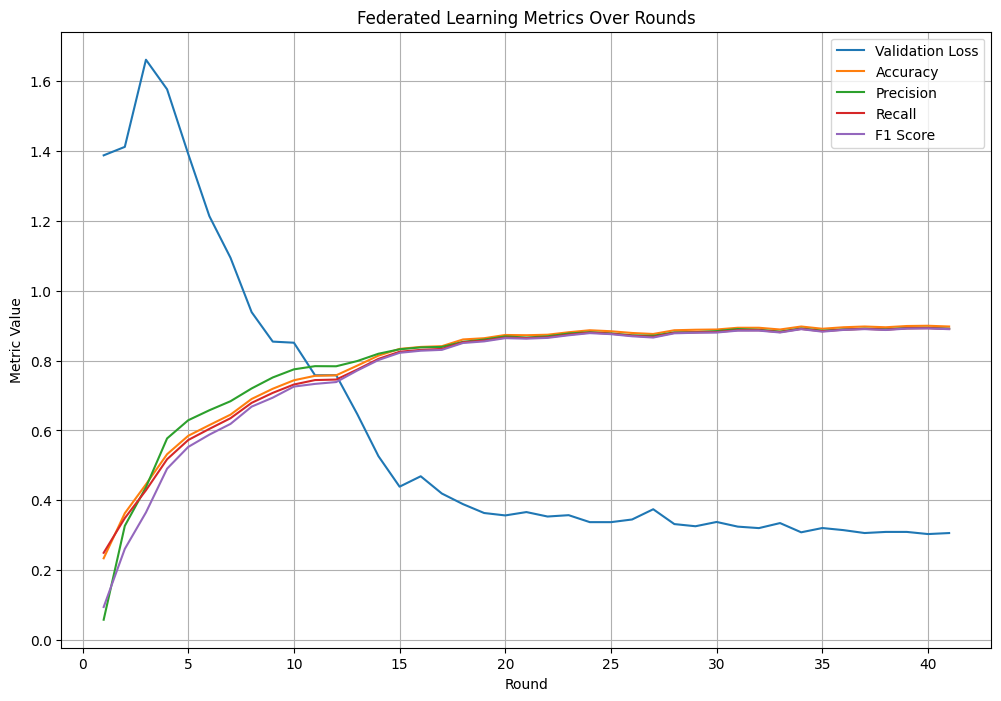

In [10]:
rounds = range(1, len(strategy.metrics_history['accuracy']) + 1)
plt.figure(figsize=(12, 8))
plt.plot(rounds, strategy.metrics_history['val_loss'], label='Validation Loss')
plt.plot(rounds, strategy.metrics_history['accuracy'], label='Accuracy')
plt.plot(rounds, strategy.metrics_history['precision'], label='Precision')
plt.plot(rounds, strategy.metrics_history['recall'], label='Recall')
plt.plot(rounds, strategy.metrics_history['f1'], label='F1 Score')
plt.xlabel('Round')
plt.ylabel('Metric Value')
plt.title('Federated Learning Metrics Over Rounds')
plt.legend()
plt.grid(True)

# Сначала сохранить
plt.savefig('/home/ir739wb/ilyarekun/bc_project/federated-learning/fed-avg-code/fed-avg-iid-graph1.png', dpi=300)

# Потом показать (если нужно)
plt.show()

# И только после этого закрыть
plt.close()


In [11]:
from flwr.common import parameters_to_ndarrays

model = get_model()

# Convert the Flower Parameters to a list of NumPy arrays
final_ndarrays = parameters_to_ndarrays(strategy.final_parameters)

# Create a state dictionary mapping each key to a torch tensor of the corresponding parameter array
state_dict = {k: torch.tensor(v) for k, v in zip(model.state_dict().keys(), final_ndarrays)}
model.load_state_dict(state_dict)
model.eval()

all_preds = []
all_targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

accuracy = (np.array(all_preds) == np.array(all_targets)).mean()
precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")


Test Accuracy: 0.9050
Test Precision: 0.8994
Test Recall: 0.8995
Test F1 Score: 0.8990


In [12]:
with open('/home/ir739wb/ilyarekun/bc_project/federated-learning/fed-avg-code/fed-avg-iid-metrics1.txt', 'w') as f:
    for round_num in rounds:
        f.write(f"Round {round_num}:\n")
        f.write(f"  Validation Loss: {strategy.metrics_history['val_loss'][round_num-1]:.4f}\n")
        f.write(f"  Accuracy: {strategy.metrics_history['accuracy'][round_num-1]:.4f}\n")
        f.write(f"  Precision: {strategy.metrics_history['precision'][round_num-1]:.4f}\n")
        f.write(f"  Recall: {strategy.metrics_history['recall'][round_num-1]:.4f}\n")
        f.write(f"  F1 Score: {strategy.metrics_history['f1'][round_num-1]:.4f}\n")
    f.write("\nTest Metrics:\n")
    f.write(f"  Accuracy: {accuracy:.4f}\n")
    f.write(f"  Precision: {precision:.4f}\n")
    f.write(f"  Recall: {recall:.4f}\n")
    f.write(f"  F1 Score: {f1:.4f}\n")
print("Metrics saved to 'fed-avg-iid-metrics1.txt'")

Metrics saved to 'fed-avg-iid-metrics1.txt'
